# 01 — Data Exploration & Pair Selection (Cointegration)

This notebook:

1. Pulls adjusted close prices (default: **Yahoo Finance via `yfinance`**)
2. Runs sanity checks + exploratory plots
3. Screens a universe of tickers for candidate pairs using:
   - Engle–Granger cointegration test
   - ADF test on the estimated spread (stationarity diagnostic)
4. Saves intermediate artifacts to `data/processed/` for reuse in later notebooks.

> **Tip:** If you already have price data (CSV / Parquet) in `data/`, you can skip the download step and point the loader to your file.

In [1]:
# Standard imports
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [2]:
# Robustly locate the repo root (works whether you run from /notebooks or elsewhere)
def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    candidates = [start] + list(start.parents)
    for p in candidates:
        if (p / "pyproject.toml").exists() or (p / "README.md").exists():
            # Prefer the directory that actually contains a "src" folder if present
            if (p / "src").exists():
                return p
            # Fallback
            return p
    return start

PROJECT_ROOT = find_repo_root()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

for d in (DATA_DIR, RAW_DIR, PROCESSED_DIR):
    d.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR

(PosixPath('/Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy'),
 PosixPath('/Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/data'),
 PosixPath('/Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/data/raw'),
 PosixPath('/Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/data/processed'))

## 1) Load price data

In [3]:
# If yfinance isn't installed, uncomment:
# !pip install yfinance

import yfinance as yf

TICKERS = [
    # Put your universe here. Keep it modest (20–80) for fast iteration.
    "NVDA", "JPM", "AMZN", "META", "AAPL", "MSFT", "GOOGL", "TSLA",
    "BAC", "GS", "MA", "V", "XOM", "CVX", "LLY", "UNH", "KO", "PEP"
]

START = "2018-01-01"
END = None  # None = today

PRICE_CACHE = PROCESSED_DIR / f"adj_close_{START}_to_{'today' if END is None else END}.parquet"

def download_adj_close(tickers, start, end=None) -> pd.DataFrame:
    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        group_by="column",
        threads=True,
    )
    # yfinance returns multi-index columns: ("Adj Close", TICKER)
    if isinstance(df.columns, pd.MultiIndex):
        if ("Adj Close" in df.columns.get_level_values(0)):
            px = df["Adj Close"].copy()
        elif ("Close" in df.columns.get_level_values(0)):
            px = df["Close"].copy()
        else:
            raise ValueError(f"Unexpected columns from yfinance: {df.columns}")
    else:
        # Single ticker case
        px = df.rename(columns={"Adj Close":"Adj Close"})[["Adj Close"]]
    px.index = pd.to_datetime(px.index)
    px = px.sort_index()
    px = px.dropna(how="all")
    return px

if PRICE_CACHE.exists():
    prices = pd.read_parquet(PRICE_CACHE)
    print(f"Loaded cached prices: {PRICE_CACHE}")
else:
    prices = download_adj_close(TICKERS, START, END)
    prices.to_parquet(PRICE_CACHE)
    print(f"Saved prices -> {PRICE_CACHE}")

prices.tail()

Saved prices -> /Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/data/processed/adj_close_2018-01-01_to_today.parquet


Ticker,AAPL,AMZN,BAC,CVX,GOOGL,GS,JPM,KO,LLY,MA,META,MSFT,NVDA,PEP,TSLA,UNH,V,XOM
Date,,,,,,,,,,,,,,,,,,
2025-12-24,273.809998,232.380005,56.250000,150.500000,314.089996,910.780029,329.170013,70.110001,1076.979980,579.450012,667.549988,488.019989,188.610001,143.740005,485.399994,327.579987,355.140015,119.220001
2025-12-26,273.399994,232.520004,56.169998,150.020004,313.510010,907.039978,327.910004,69.870003,1077.750000,579.599976,663.289978,487.709991,190.529999,143.779999,475.190002,331.829987,355.000000,119.110001
2025-12-29,273.760010,232.070007,55.349998,150.990005,313.559998,892.179993,323.750000,70.160004,1078.729980,577.900024,658.690002,487.100006,188.220001,144.240005,459.640015,328.940002,354.609985,120.529999
2025-12-30,273.079987,232.529999,55.279999,152.309998,313.850006,884.419983,323.420013,70.070000,1079.750000,577.419983,665.950012,487.480011,187.539993,144.160004,454.429993,332.160004,353.619995,120.989998
2025-12-31,271.859985,230.820007,55.000000,152.410004,313.000000,879.000000,322.220001,69.910004,1074.680054,570.880005,660.090027,483.619995,186.500000,143.520004,449.720001,330.109985,350.709991,120.339996


## 2) Data audit / sanity checks

In [4]:
# Basic audit
audit = pd.DataFrame({
    "n_obs": prices.notna().sum(),
    "pct_missing": prices.isna().mean().round(4),
    "start": prices.apply(lambda s: s.first_valid_index()),
    "end": prices.apply(lambda s: s.last_valid_index()),
})
audit.sort_values("pct_missing", ascending=False).head(10)

,n_obs,pct_missing,start,end
Ticker,,,,
AAPL,2011,0.0,2018-01-02,2025-12-31
AMZN,2011,0.0,2018-01-02,2025-12-31
V,2011,0.0,2018-01-02,2025-12-31
UNH,2011,0.0,2018-01-02,2025-12-31
TSLA,2011,0.0,2018-01-02,2025-12-31
PEP,2011,0.0,2018-01-02,2025-12-31
NVDA,2011,0.0,2018-01-02,2025-12-31
MSFT,2011,0.0,2018-01-02,2025-12-31
META,2011,0.0,2018-01-02,2025-12-31


In [5]:
# Drop tickers with too much missingness (common if IPO'd later)
MAX_MISSING = 0.10
keep = audit.query("pct_missing <= @MAX_MISSING").index.tolist()
dropped = sorted(set(prices.columns) - set(keep))
print("Keeping:", keep)
print("Dropped:", dropped)

prices = prices[keep].copy()
prices = prices.dropna(how="any")  # align to common dates for pair testing
prices.shape

Keeping: ['AAPL', 'AMZN', 'BAC', 'CVX', 'GOOGL', 'GS', 'JPM', 'KO', 'LLY', 'MA', 'META', 'MSFT', 'NVDA', 'PEP', 'TSLA', 'UNH', 'V', 'XOM']
Dropped: []


(2011, 18)

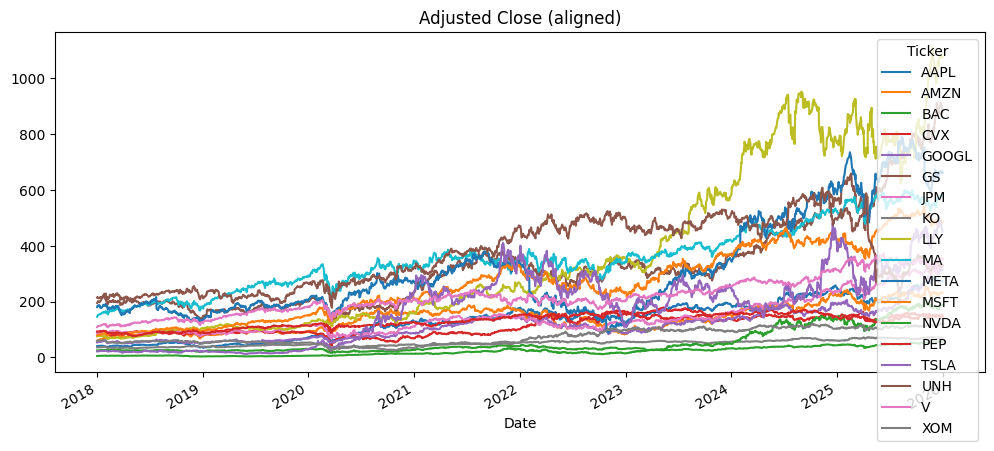

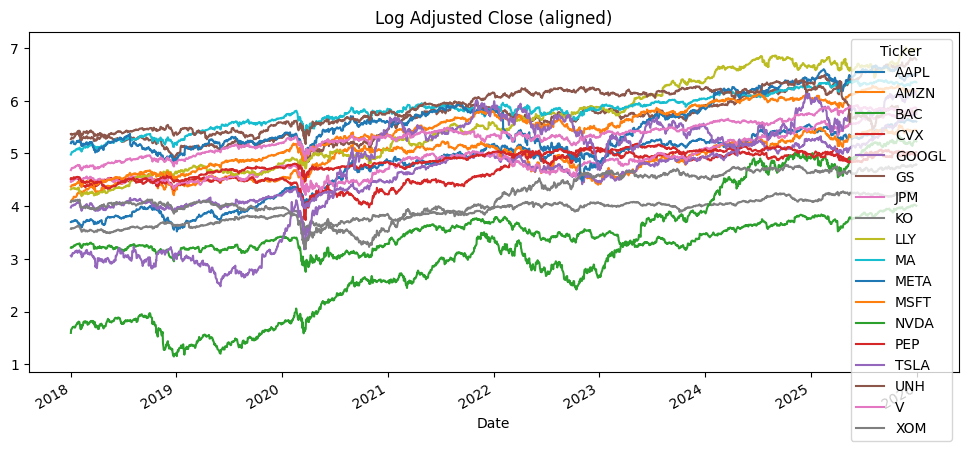

In [6]:
# Quick visualization
prices.plot(title="Adjusted Close (aligned)", figsize=(12, 5))
plt.show()

log_prices = np.log(prices)
log_prices.plot(title="Log Adjusted Close (aligned)", figsize=(12, 5))
plt.show()

## 3) Pair selection: cointegration + spread stationarity diagnostic

In [7]:
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

def estimate_hedge_ratio(y: pd.Series, x: pd.Series) -> float:
    # OLS y ~ a + b*x
    x_ = sm.add_constant(x.values)
    model = sm.OLS(y.values, x_).fit()
    beta = model.params[1]
    return float(beta)

def compute_spread(y: pd.Series, x: pd.Series, beta: float) -> pd.Series:
    return y - beta * x

def adf_pvalue(series: pd.Series) -> float:
    res = adfuller(series.dropna().values, autolag="AIC")
    return float(res[1])

def screen_pairs(prices: pd.DataFrame, max_pairs: int | None = None) -> pd.DataFrame:
    results = []
    cols = list(prices.columns)
    pairs = list(combinations(cols, 2))
    if max_pairs is not None:
        pairs = pairs[:max_pairs]
    for a, b in pairs:
        y = np.log(prices[a])
        x = np.log(prices[b])
        # Engle–Granger cointegration test
        coint_t, coint_p, _ = coint(y, x)
        beta = estimate_hedge_ratio(y, x)
        spread = compute_spread(y, x, beta)
        adf_p = adf_pvalue(spread)
        results.append({
            "asset_a": a,
            "asset_b": b,
            "coint_p": coint_p,
            "adf_p_spread": adf_p,
            "beta": beta,
            "n_days": int(spread.dropna().shape[0]),
        })
    out = pd.DataFrame(results).sort_values(["coint_p", "adf_p_spread"])
    return out.reset_index(drop=True)

pair_results = screen_pairs(prices)
pair_results.head(15)

,asset_a,asset_b,coint_p,adf_p_spread,beta,n_days
0,MA,V,0.001742,0.000289,1.119696,2011
1,MA,MSFT,0.010223,0.002114,0.607626,2011
2,AMZN,META,0.014291,0.003086,0.597664,2011
3,KO,LLY,0.022414,0.005209,0.239020,2011
4,CVX,XOM,0.031437,0.007731,0.701559,2011
5,KO,MA,0.044756,0.011729,0.582055,2011
6,MA,NVDA,0.047873,0.012111,0.251152,2011
7,MA,META,0.053196,0.014393,0.547301,2011
8,GOOGL,GS,0.055568,0.015184,0.949379,2011
9,BAC,GOOGL,0.056932,0.015624,0.483679,2011


In [8]:
# Select candidate pairs
COINT_P_MAX = 0.05  # typical significance threshold
candidates = pair_results.query("coint_p <= @COINT_P_MAX").copy()

print(f"Pairs with cointegration p <= {COINT_P_MAX}: {len(candidates)} / {len(pair_results)}")
candidates.head(20)

Pairs with cointegration p <= 0.05: 7 / 153


,asset_a,asset_b,coint_p,adf_p_spread,beta,n_days
0,MA,V,0.001742,0.000289,1.119696,2011
1,MA,MSFT,0.010223,0.002114,0.607626,2011
2,AMZN,META,0.014291,0.003086,0.597664,2011
3,KO,LLY,0.022414,0.005209,0.239020,2011
4,CVX,XOM,0.031437,0.007731,0.701559,2011
5,KO,MA,0.044756,0.011729,0.582055,2011
6,MA,NVDA,0.047873,0.012111,0.251152,2011


In [9]:
# Save screening output for notebook 02
screen_path = PROCESSED_DIR / "pair_screening.parquet"
candidates.to_parquet(screen_path)
print(f"Saved -> {screen_path}")

Saved -> /Users/samiaibrahim/Pairs-Trading-Statistical-Arbitrage-Strategy/data/processed/pair_screening.parquet


## 4) Deep dive on a chosen pair

{'pair': 'AMZN-MA', 'coint_p': np.float64(0.1956716672855886), 'beta': 0.9025017754749416, 'adf_p_spread': 0.07228308543887285}


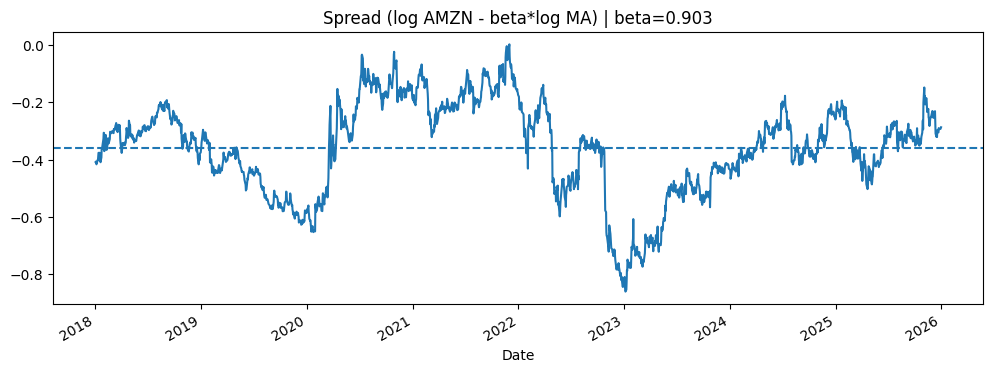

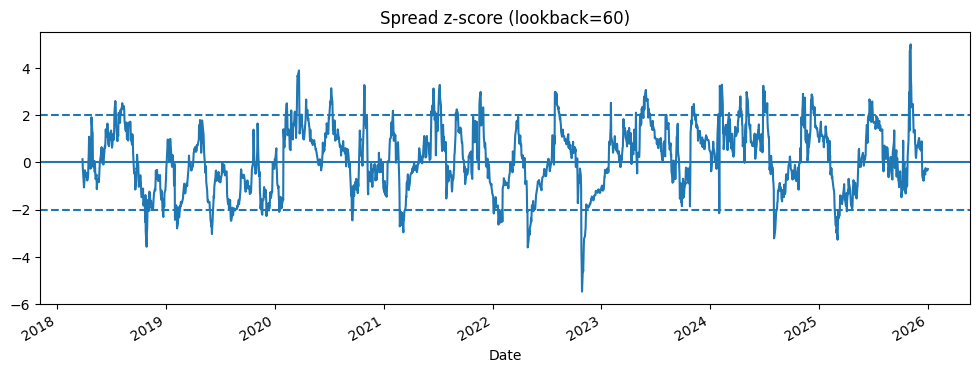

In [10]:
PAIR = ("AMZN", "MA")  # change me

a, b = PAIR
y = np.log(prices[a])
x = np.log(prices[b])

coint_t, coint_p, _ = coint(y, x)
beta = estimate_hedge_ratio(y, x)
spread = compute_spread(y, x, beta)

print({"pair": f"{a}-{b}", "coint_p": coint_p, "beta": beta, "adf_p_spread": adf_pvalue(spread)})

fig, ax = plt.subplots(figsize=(12, 4))
spread.plot(ax=ax, title=f"Spread (log {a} - beta*log {b}) | beta={beta:.3f}")
ax.axhline(spread.mean(), linestyle="--")
plt.show()

# Z-score of spread
lookback = 60
z = (spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()

fig, ax = plt.subplots(figsize=(12, 4))
z.plot(ax=ax, title=f"Spread z-score (lookback={lookback})")
ax.axhline(2, linestyle="--")
ax.axhline(-2, linestyle="--")
ax.axhline(0, linestyle="-")
plt.show()

## 5) Diagnostic: stability over time (rolling tests)

Cointegration is *not* a guarantee of tradable mean reversion. Two quick stress tests:

- **Rolling correlation** of returns (relationship drift)
- **Rolling ADF p-value** of the spread (mean reversion drift)

If these degrade, a static hedge ratio + static entry thresholds can get crushed in regime shifts.

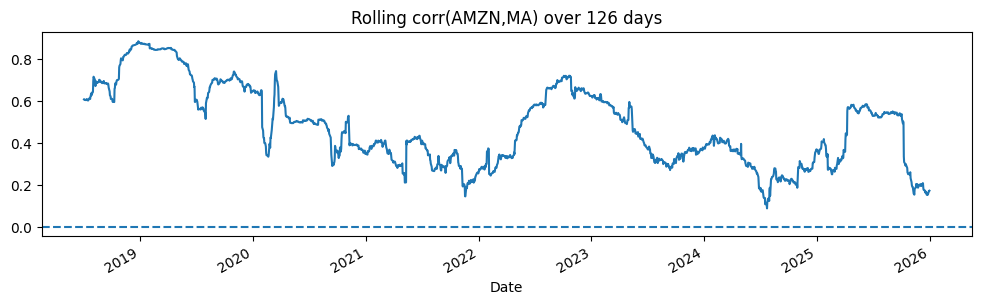

In [11]:
# Rolling correlation of daily returns
rets = prices.pct_change().dropna()
roll = 126  # ~6 months

rolling_corr = rets[a].rolling(roll).corr(rets[b])

fig, ax = plt.subplots(figsize=(12, 3))
rolling_corr.plot(ax=ax, title=f"Rolling corr({a},{b}) over {roll} days")
ax.axhline(0, linestyle="--")
plt.show()

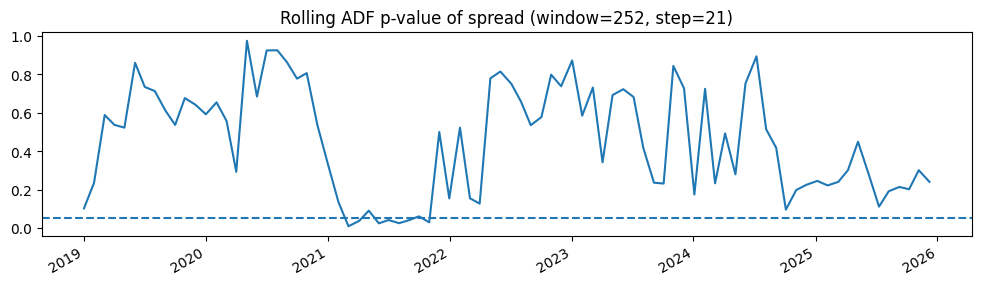

In [12]:
# Rolling ADF p-value on the spread (expensive but informative)
def rolling_adf_pvalues(series: pd.Series, window: int = 252, step: int = 21) -> pd.Series:
    out = {}
    idx = series.index
    for end_i in range(window, len(series)+1, step):
        window_series = series.iloc[end_i-window:end_i]
        out[idx[end_i-1]] = adf_pvalue(window_series)
    return pd.Series(out).sort_index()

roll_adf = rolling_adf_pvalues(spread.dropna(), window=252, step=21)

fig, ax = plt.subplots(figsize=(12, 3))
roll_adf.plot(ax=ax, title=f"Rolling ADF p-value of spread (window=252, step=21)")
ax.axhline(0.05, linestyle="--")
plt.show()